In [1]:
!pip install datasets
!pip install emoji

!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=194b46da919e98e83f5b1db54cc23dca24ce9f946c305c8c42e78c139d32461d
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji
2023-07-04 19:38:40.984495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
T

In [2]:
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt
import emoji
import os

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from datasets import load_dataset
from unicodedata import normalize
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


import pandas as pd
import csv
import spacy
import emoji
from unicodedata import normalize
from tqdm import tqdm
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import random
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

def preprocessar_tweets(tweets):
    nlp = spacy.load('pt_core_news_sm')
    repetion_pattern = re.compile(r'(.)\1\1+')
    new_tweets = []
    with tqdm(total=len(tweets), colour='green', desc='Processando') as pbar:
      for tweet in tweets[1:]:
          tweet[0] = emoji.demojize(tweet[0], language='pt')
          tweet[0] = tweet[0].replace('_', ' ')
          tweet[0] = normalize('NFKD', tweet[0]).encode('ASCII', 'ignore').decode('ASCII')
          tweet[0] = repetion_pattern.sub(r'\1', tweet[0])
          tweet[0] = re.sub(r'@\w+', ' ', tweet[0])
          tweet[0] = re.sub(r'\s\s+', ' ', tweet[0])
          doc = nlp(tweet[0])
          tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and not t.is_stop and len(t.lemma_) > 1]
          new_tweet = ' '.join(tokens)
          tweet[0]=(tweet[0].strip())
          tweet[1]=int(tweet[1])
          tweet[2]=int(tweet[2])
          tweet[3]=tweet[3].replace(",", ".", 1)
          tweet[3]=int (float(tweet[3]))
          if(tweet[3]==-1):
            tweet[3]=10
          new_tweets.append(tweet)
          pbar.update(1)

    return new_tweets

def ler_csv(arquivo):
    matriz = []

    with open(arquivo, 'r') as csv_file:
        leitor = csv.reader(csv_file)

        for linha in leitor:
            matriz.append(linha)

    return matriz

In [5]:
matriz = ler_csv('/content/drive/MyDrive/5d/HateBR.csv')
print(matriz[2])
dataset=preprocessar_tweets(matriz)
#dataset= random.shuffle(dataset)

['Mais um lixo', '1', '1', '-1']


Processando: 100%|█████████▉| 7000/7001 [01:26<00:00, 80.90it/s]


In [6]:
X=np.array(dataset)
dataset[0]

['este lixo .', 1, 1, 10]

# Modificar o valor de "l" para definir o teste:
## 1 para testar se o comentario é ofencivo ou não
## 3 para testar se o comentario qual tipo de discurso de odio o comentario tem

In [7]:
X=np.array(dataset)[:,0]
y =  np.array(dataset)[:,[1]]


In [8]:
n_rows=-1
# Separar em conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separar em conjunto de treinamento e conjunto de validação
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
tokenizer = Tokenizer(oov_token='<oov>')

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_validation)
X_test = tokenizer.texts_to_sequences(X_test)

print(f'\n\nSeq. Tweet Train: {X_train[0]}')
print(f'Seq. Tweet Validation: {X_val[0]}')
print(f'Seq. Tweet Test: {X_test[0]}')



Seq. Tweet Train: [23, 2148]
Seq. Tweet Validation: [29, 2, 7, 3012, 13, 193, 1674, 2, 383, 2, 19, 1218, 3, 2000, 77, 11, 210, 189, 967, 7, 4161]
Seq. Tweet Test: [67, 207]


In [10]:
max_len = max([len(x) for x in X_train])

print(max_len)

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')


220


# Montar os MODELOS

In [11]:
def build_simple_model(max_len, num_classes):
  model = models.Sequential()
  model.add(layers.Dense(units=256, input_shape=(max_len,), activation='relu'))
  model.add(layers.Dense(units=num_classes, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def build_simple_model_embedding(max_len, vocab_size, embedding_dim, num_classes):
   model = models.Sequential()
   model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                              input_length=max_len))
   model.add(layers.Flatten())
   model.add(layers.Dense(units=64, activation='relu'))
   model.add(layers.Dense(units=num_classes, activation='sigmoid'))
   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
   return model


def build_cnn_model(vocab_size, max_len, num_classes, embedding_dim=100, \
                    num_filters=32, kernel_size=3):
  model = models.Sequential()
  model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                             input_length=max_len))
  model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
  model.add(layers.GlobalMaxPool1D())
  model.add(layers.Dense(units=64, activation='relu'))
  model.add(layers.Dense(units=num_classes, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def build_bilstm(vocab_size, max_len, num_classes, embedding_dim=100):
  model = models.Sequential()
  model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                             input_length=max_len))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Bidirectional(layers.LSTM(units=128)))
  model.add(layers.Dropout(rate=0.2))
  model.add(layers.Dense(units=64, activation='relu'))
  model.add(layers.Dense(units=num_classes, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [12]:
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(np.unique(y))

print('\nVocab size:', vocab_size)

y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_validation, num_classes=num_classes)

print('\nTrain Labels:', y_train[0], '-', y_train[0])
print('Validation Labels:', y_validation[0], '-', y_val[0])


Vocab size: 7283

Train Labels: [0. 1.] - [0. 1.]
Validation Labels: ['1'] - [0. 1.]


In [13]:
num_classes

2

In [14]:
def selec_model(model_option):

  if model_option == 1:
    model = build_simple_model(max_len, num_classes)
  elif model_option == 2:
    model = build_simple_model_embedding(max_len, vocab_size, embedding_dim=100, \
                                       num_classes=num_classes)
  elif model_option == 3:
    model = build_cnn_model(vocab_size, max_len, num_classes, embedding_dim=100, \
                          num_filters=32, kernel_size=3)
  elif model_option == 4:
    model = build_bilstm(vocab_size, max_len, num_classes, embedding_dim=100)

  return model

In [15]:
def his(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='upper left')

  plt.show()

In [16]:
def plot_his(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='upper left')

  plt.show()

# Selecionar Modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               56576     
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 57,090
Trainable params: 57,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
33/33 [==============================] - 2s 19ms/step - loss: 44.6203 - accuracy: 0.5043 - val_loss: 23.6131 - val_accuracy: 0.4850
Epoch 2/20
33/33 [==============================] - 0s 9ms/step - loss: 21.2227 - accuracy: 0.5345 - val_loss: 18.8349 - val_accuracy: 0.5043
Epoch 3/20
33/33 [==============================] - 0s 8ms/step - loss: 14.4743 - accuracy: 0.5621 - val_loss: 17.0255 - val_accuracy: 0.5143
Epoch 4/20
33/33 [===

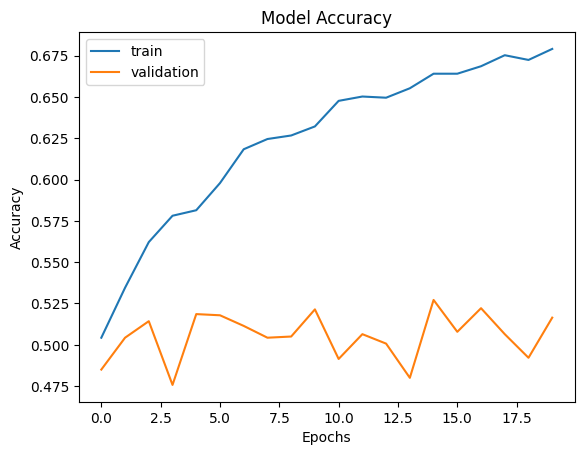

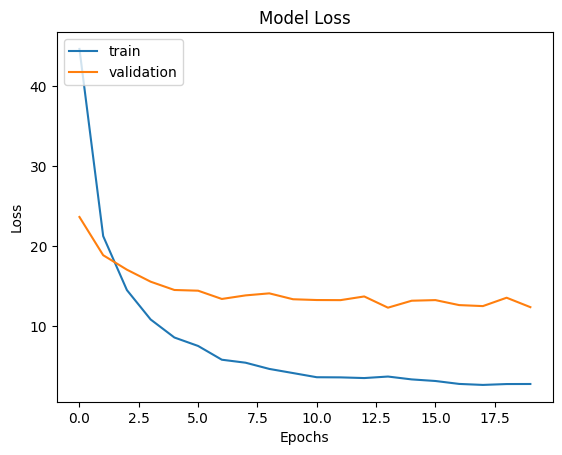

44/44 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       689
           1       0.53      0.51      0.52       711

    accuracy                           0.52      1400
   macro avg       0.52      0.52      0.52      1400
weighted avg       0.52      0.52      0.52      1400



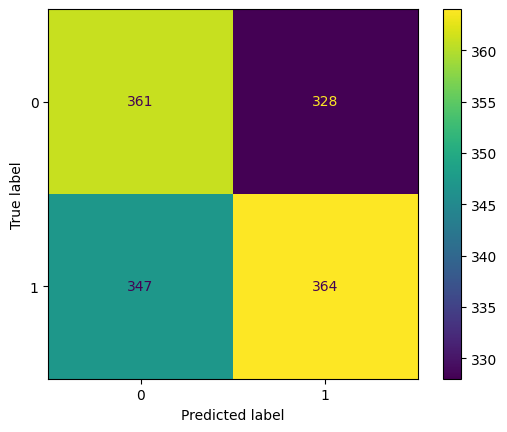

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 220, 100)          728300    
                                                                 
 flatten (Flatten)           (None, 22000)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1408064   
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,136,494
Trainable params: 2,136,494
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
33/33 [==============================] - 4s 93ms/step - loss: 0.6904 - accuracy: 0.5398 - val_loss: 0.6694 - val_accuracy: 0.5393
Epoch 2/20
33/33 [=================

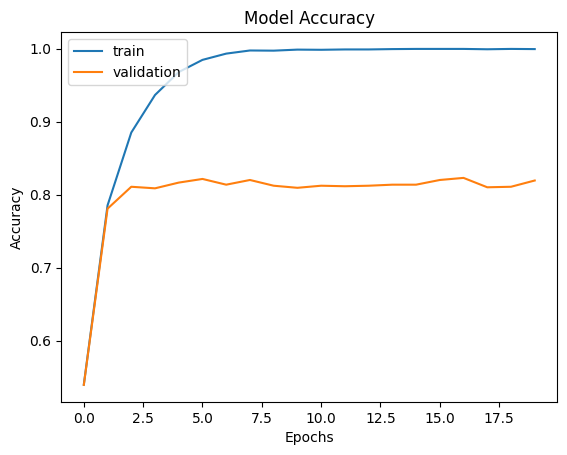

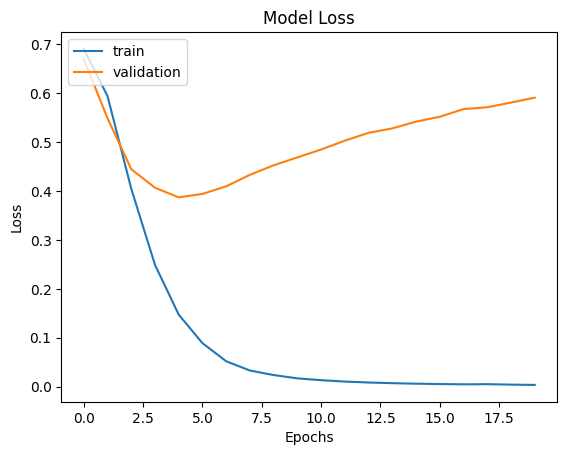

44/44 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       689
           1       0.83      0.86      0.85       711

    accuracy                           0.84      1400
   macro avg       0.84      0.84      0.84      1400
weighted avg       0.84      0.84      0.84      1400



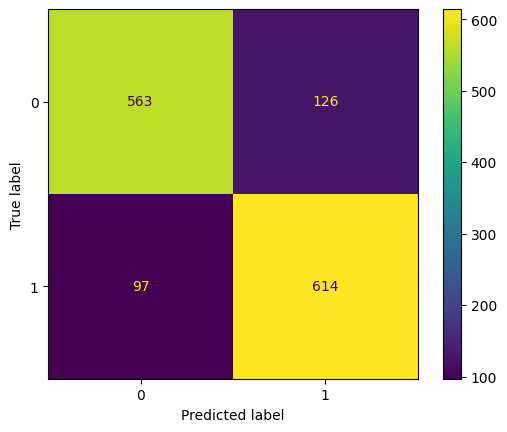

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 220, 100)          728300    
                                                                 
 conv1d (Conv1D)             (None, 218, 32)           9632      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 740,174
Trainable params: 740,174
Non-trainable params: 0
________________________________________________

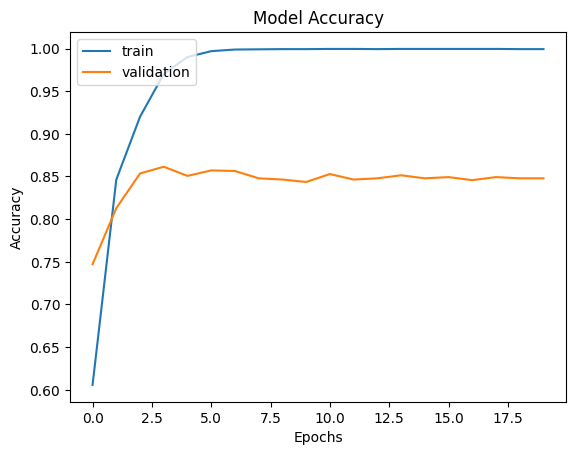

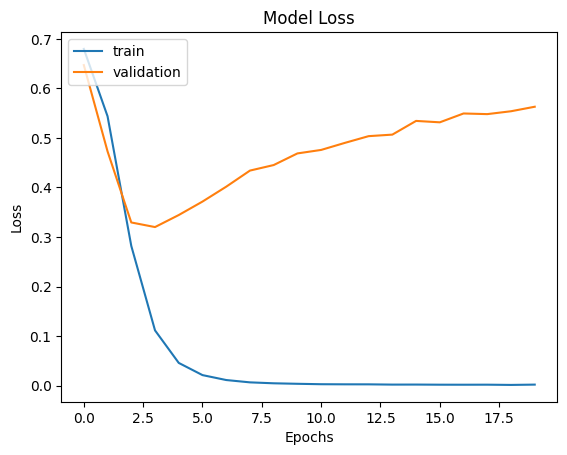

44/44 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       689
           1       0.85      0.89      0.87       711

    accuracy                           0.86      1400
   macro avg       0.87      0.86      0.86      1400
weighted avg       0.87      0.86      0.86      1400



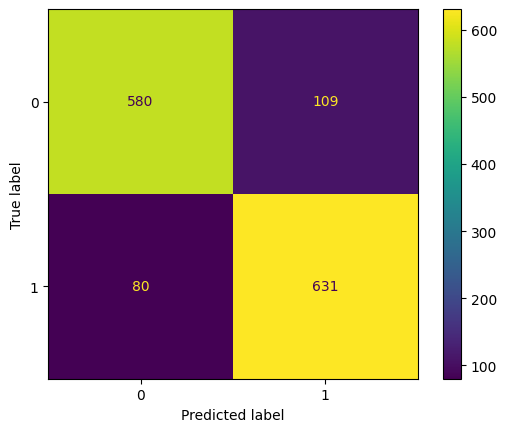

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 220, 100)          728300    
                                                                 
 dropout (Dropout)           (None, 220, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                      

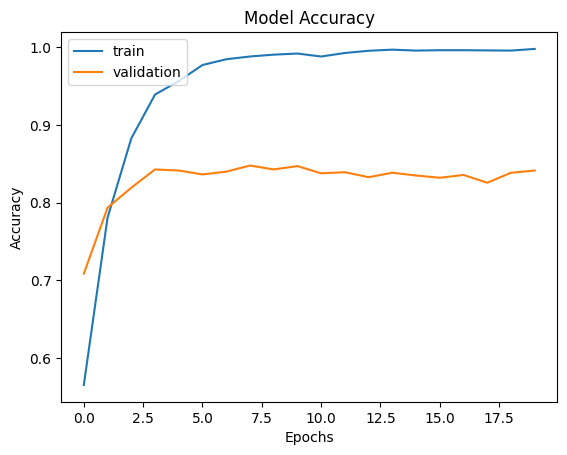

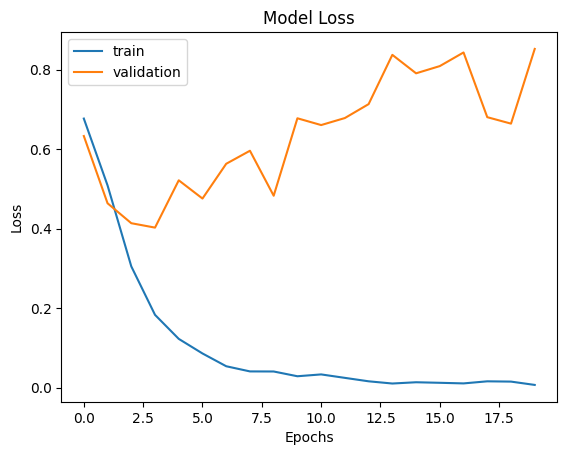

44/44 [==============================] - 12s 234ms/step
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       689
           1       0.84      0.87      0.86       711

    accuracy                           0.85      1400
   macro avg       0.85      0.85      0.85      1400
weighted avg       0.85      0.85      0.85      1400



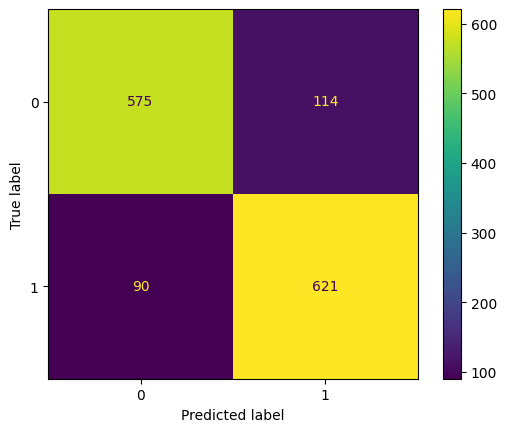

In [17]:
for model_option in range(4):

  model = selec_model(model_option+1)
  model.summary()
  checkpoint_dir = '/content/model_checkpoint/'

  os.makedirs(checkpoint_dir, exist_ok=True)

  model_checkpoint = ModelCheckpoint(filepath=checkpoint_dir, \
                                     save_weights_only=True, monitor='val_accuracy', \
                                     mode='max', save_best_only=True)

  history = model.fit(X_train, y_train, batch_size=128, epochs=20, \
                      validation_data=(X_val, y_val), callbacks=[model_checkpoint])

  model.load_weights(checkpoint_dir)

  his(history)
  plot_his(history)
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_test=y_test.astype(int)
  report = classification_report(y_test, y_pred, zero_division=0)

  print(report)
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

  plt.show()